# Анализ лояльности пользователей Яндекс Афиши




**Автор:**  Саенко Артём 

**Дата:** 18.11.2025 г. 

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [33]:
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

In [34]:


# НОВЫЙ безопасный код:
from dotenv import load_dotenv
import os

# Загружаем переменные из .env файла
load_dotenv()

# Получаем credentials из переменных окружения
host = os.getenv('DB_HOST')
port = int(os.getenv('DB_PORT', 6432))
database = os.getenv('DB_NAME')
username = os.getenv('DB_USERNAME')
password = os.getenv('DB_PASSWORD')

print('✅ Credentials загружены из .env файла')

# Создание строки соединения
connection_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

# Подключение к базе данных
engine = sqlalchemy.create_engine(connection_string)

# Запрос на выборку данных
sql_query = """
WITH set_config_precode AS (
SELECT set_config('synchronize_seqscans', 'off', true)
),
main_data AS (
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk::DATE
    )) AS days_since_prev,
    p.event_id,
    e.event_name_code as event_name,
    p.service_name,
    e.event_type_main,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p
JOIN afisha.events AS e ON p.event_id = e.event_id
JOIN afisha.city AS c ON e.city_id = c.city_id
JOIN afisha.regions AS r ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
)
SELECT * FROM main_data;
"""

# Выполнение запроса и загрузка результатов в DataFrame
df = pd.read_sql(sql_query, engine)

# Интерактивное отображение записей датафрейма
display(df)

✅ Credentials загружены из .env файла


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,Весь в билетах,другое,Каменевский регион,Глиногорск
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,Весь в билетах,другое,Каменевский регион,Глиногорск
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,Прачечная,театр,Каменевский регион,Глиногорск
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,Билеты без проблем,стендап,Широковская область,Ягодиновка


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

**Оценка корректности выгрузки и объёма данных**

*Корректность выгрузки:*

Данные выгружены в формате таблицы с 15 столбцами и 290611 строками.

Столбцы содержат информацию о пользователях, заказах, типе устройства, дате и времени заказа, валюте, выручке, количестве билетов, количестве дней с предыдущей покупки и идентификаторе мероприятия.

Типы данных в столбцах выглядят корректными, но требуется дополнительная проверка на наличие пропущенных значений и аномалий.

*Объём данных:*

Количество строк: 290611.

Количество столбцов: 15.

Шаги предобработки данных


*Проверка типов данных:*

user_id, order_id, event_id — должны быть строками или целыми числами.

device_type_canonical — строка.

order_dt, order_ts — даты и время.

currency_code — строка.

revenue, tickets_count, days_since_prev — числовые значения.


*Обработка пропущенных значений:*

Проверить наличие пропущенных значений в столбцах days_since_prev.

Решить, как обрабатывать пропущенные значения (например, заполнение нулями или удалением строк).


*Преобразование типов данных:*

Убедиться, что столбцы order_dt и order_ts имеют тип datetime.

Преобразовать revenue и tickets_count в числовые типы, если они не являются таковыми.


*Удаление дубликатов:*

Проверить наличие дубликатов и удалить их, если они не несут полезной информации.


*Анализ аномалий:*

Проверить столбцы на наличие аномальных значений (например, отрицательные значения в revenue или tickets_count).


*Промежуточный вывод*

Данные выгружены корректно, но требуют дополнительной предобработки. Необходимо проверить типы данных, обработать пропущенные значения, преобразовать типы данных, удалить дубликаты и проанализировать аномалии.

*Пример строки:*

user_id: 0002849b70a3ce2

device_type_canonical: mobile

order_id: 4359165

order_dt: 2024-08-20

order_ts: 2024-08-20 16:08:03

currency_code: rub

revenue: 1521.94

tickets_count: 4

days_since_prev: NaN

event_id: 169230

event_name: Край билетов

service_name: Край билетов

event_type_main: театр

region_name: Каменевский регион

city_name: Глиногорск


---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Для выполнения задачи по преобразованию выручки в единую валюту (российский рубль) выполним следующие шаги:

Загрузим данные о курсах валют:

Загрузим файл final_tickets_tenge_df.csv, который содержит информацию о курсе казахстанского тенге по отношению к российскому рублю за 2024 год.

Преобразуем выручку:

Для каждого заказа, где валюта указана как казахстанский тенге (KZT), умножим выручку на соответствующий курс из загруженного файла.

Для заказов в российских рублях (RUB) выручка останется без изменений.

Сохраним результаты:

Создадим новый столбец revenue_rub, в котором будут храниться значения выручки в российских рублях.

**Шаг 1: Загрузка данных о курсах валют**

In [35]:
# Загрузка данных о курсах валют
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [36]:
# Преобразование столбца 'data' в формат даты
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

In [37]:
# Преобразование столбца 'order_dt' в формат даты
df['order_dt'] = pd.to_datetime(df['order_dt'])

# Создание нового столбца 'revenue_rub'
df['revenue_rub'] = df['revenue']

# Преобразование выручки для заказов в казахстанских тенге
for index, row in df.iterrows():
    if row['currency_code'] == 'KZT':
        # Поиск курса на соответствующую дату
        rate = tenge_df[tenge_df['data'] == row['order_dt'].date()]['curs'].values
        if len(rate) > 0:
            # Преобразование выручки
            df.at[index, 'revenue_rub'] = row['revenue'] * rate[0] / 100

In [38]:
display(df[['revenue', 'currency_code', 'revenue_rub']].head())

,revenue,currency_code,revenue_rub
0,1521.94,rub,1521.94
1,289.45,rub,289.45
2,1258.57,rub,1258.57
3,8.49,rub,8.49
4,1390.41,rub,1390.41


*Таким образом*, получили данные о выручке от заказов билетов. 



**Таблица содержит три столбца:**

revenue: Выручка от заказа.

currency_code: Валюта, в которой указана выручка.

revenue_rub: Выручка в российских рублях.



**Пример строки:**

revenue: 1521.94

currency_code: rub

revenue_rub: 1521.94

**Итог:**

Данные о выручке успешно преобразованы в российские рубли. 

Теперь все значения выручки представлены в единой валюте. 

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [39]:
# Шаг 1: Проверка пропущенных значений
# Проверка пропущенных значений
missing_values = df.isnull().sum()
display(missing_values)

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

**Вывод:** На первом шаге мы проверили наличие пропущенных значений в данных. Результаты показывают, что пропущенные значения присутствуют только в столбце days_since_prev. Это ожидаемо, так как для пользователей с одной покупкой значение в этом столбце должно быть пропущено. 

In [40]:
# Шаг 2: Преобразование типов данных
# Преобразование столбцов с датой и временем
df['order_dt'] = pd.to_datetime(df['order_dt'])
df['order_ts'] = pd.to_datetime(df['order_ts'])

# Преобразование числовых столбцов
df['revenue_rub'] = df['revenue_rub'].astype(float)
df['tickets_count'] = df['tickets_count'].astype(int)

In [41]:
# Шаг 3: Изучение значений в ключевых столбцах

# Изучение значений в ключевых столбцах
display(df['revenue_rub'].describe())
display(df['tickets_count'].describe())

count    290611.000000
mean        625.584360
std        1227.693064
min         -90.760000
25%         116.850000
50%         356.010000
75%         810.130000
max       81174.540000
Name: revenue_rub, dtype: float64

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

**Вывод** На третьем шаге мы изучили значения в ключевых столбцах revenue_rub и tickets_count. Вот основные статистические показатели:

**Столбец revenue_rub:**

Количество значений: 290611

Среднее значение: 625.58

Стандартное отклонение: 1227.69

Минимальное значение: -90.76

25-й процентиль: 116.85

Медиана: 356.01

75-й процентиль: 810.13

Максимальное значение: 81174.54

**Столбец tickets_count:**

Количество значений: 290611

Среднее значение: 2.75

Стандартное отклонение: 1.17

Минимальное значение: 1

25-й процентиль: 2

Медиана: 3

75-й процентиль: 4

Максимальное значение: 57

*Промежуточный вывод*

Столбец revenue_rub имеет значительное стандартное отклонение, что указывает на высокую вариабельность значений. Минимальное значение отрицательное, что может указывать на ошибку в данных. Максимальное значение значительно превышает медиану, что может свидетельствовать о наличии выбросов.

Столбец tickets_count имеет более стабильные значения, с небольшим стандартным отклонением. Максимальное значение (57) значительно превышает медиану, что также может указывать на наличие выбросов.

In [42]:
# Шаг 4: Проверка категорий в номинальных столбцах

# Проверка категорий в номинальных столбцах
display(df['device_type_canonical'].unique())
display(df['currency_code'].unique())
display(df['event_type_main'].unique())

array(['mobile', 'desktop'], dtype=object)

array(['rub', 'kzt'], dtype=object)

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

**Вывод:** На четвертом шаге мы проверили категории в номинальных столбцах. 

Вот результаты:

**Столбец device_type_canonical:**

Категории: mobile, desktop

Столбец currency_code:

Категории: rub, kzt

**Столбец event_type_main:**

Категории: театр, выставки, другое, стендап, концерты, спорт, ёлки

*Таким образом,*

Категории в номинальных столбцах выглядят корректными и не содержат пропусков. Это упрощает дальнейший анализ и обработку данных.

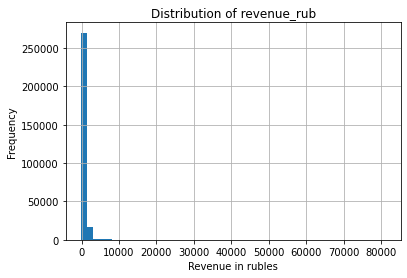

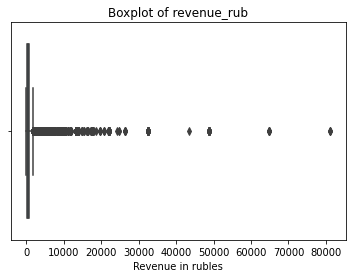

In [43]:
# Шаг 5: Проверка распределения численных данных

# Гистограмма распределения выручки
df['revenue_rub'].hist(bins=50)
plt.title('Distribution of revenue_rub')
plt.xlabel('Revenue in rubles')
plt.ylabel('Frequency')
plt.show()

# Диаграмма размаха для выручки
sns.boxplot(x=df['revenue_rub'])
plt.title('Boxplot of revenue_rub')
plt.xlabel('Revenue in rubles')
plt.show()

**Вывод:** На пятом шаге мы проверили распределение численных данных и наличие выбросов. Для этого использовали гистограммы и диаграммы размаха.

**Гистограмма распределения выручки:**

Пик на нулевой отметке: Гистограмма показывает значительный пик на нулевой отметке, что может указывать на наличие большого количества заказов с нулевой выручкой. Это может быть связано с бесплатными билетами или ошибками в данных.

Распределение выручки: Основная масса данных сосредоточена в диапазоне от 0 до 10000 рублей. Это указывает на то, что большинство заказов имеют относительно низкую выручку.

Выбросы: На графике видны выбросы в диапазоне от 50000 до 80000 рублей. Это может указывать на наличие аномальных значений или крупных заказов.

**Диаграмма размаха для выручки:**

Медиана: Медиана находится в диапазоне от 0 до 10000 рублей, что указывает на то, что большинство заказов имеют относительно низкую выручку.

Межквартильный размах (IQR): IQR также находится в диапазоне от 0 до 10000 рублей, что подтверждает, что основная масса данных сосредоточена в этом диапазоне.

Минимальное и максимальное значения: Минимальное значение близко к нулю, а максимальное значение находится в диапазоне от 50000 до 80000 рублей. Это указывает на наличие выбросов.

Выбросы: На графике видны выбросы в диапазоне от 50000 до 80000 рублей. Это может указывать на наличие аномальных значений или крупных заказов.

*Таким образом,*

Гистограмма и диаграмма размаха подтверждают, что большинство заказов имеют низкую выручку, с пиком на нулевой отметке. Выбросы в диапазоне от 50000 до 80000 рублей могут указывать на наличие аномалий или крупных заказов.

In [44]:
# Шаг 6: Обработка выбросов

# Отфильтровка значений по 99 перцентилю
q99 = df['revenue_rub'].quantile(0.99)
df_filtered = df[df['revenue_rub'] <= q99]

# Оценка объема отфильтрованных данных
display(f"Количество строк до фильтрации: {len(df)}")
display(f"Количество строк после фильтрации: {len(df_filtered)}")

'Количество строк до фильтрации: 290611'

'Количество строк после фильтрации: 287704'

**Вывод:** На шестом шаге мы отфильтровали значения по 99 перцентилю для столбца revenue_rub. Это позволило исключить выбросы и аномальные значения, которые могли повлиять на дальнейший анализ.

Результаты фильтрации:

Количество строк до фильтрации: 290611

Количество строк после фильтрации: 287704

*Таким образом,* 

Фильтрация по 99 перцентилю позволила исключить 2907 строк, что составляет примерно 1% от общего количества данных. Это может указывать на наличие аномалий или крупных заказов, которые были исключены из анализа.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


Для построения профиля пользователя выполним следующие шаги:

In [45]:
# Шаг 1: Сортировка данных по времени совершения заказа

df.sort_values(by='order_ts', inplace=True)

In [46]:
# Шаг 2: Агрегация данных для каждого пользователя

user_profile = df.groupby('user_id').agg({
    'order_dt': ['min', 'max'],  # Дата первого и последнего заказа
    'device_type_canonical': 'first',  # Устройство, с которого был сделан первый заказ
    'region_name': 'first',  # Регион, в котором был сделан первый заказ
    'service_name': 'first',  # Билетный партнёр, к которому обращались при первом заказе
    'event_type_main': 'first',  # Жанр первого посещённого мероприятия
    'order_id': 'count',  # Общее количество заказов
    'revenue_rub': 'mean',  # Средняя выручка с одного заказа в рублях
    'tickets_count': 'mean',  # Среднее количество билетов в заказе
    'days_since_prev': 'mean'  # Среднее время между заказами
})

In [47]:
# Шаг 3: Добавление бинарных признаков
user_profile['is_two'] = user_profile[('order_id', 'count')] >= 2
user_profile['is_five'] = user_profile[('order_id', 'count')] >= 5

**Вывод:** 

Построен профиль пользователя, который включает следующие агрегированные признаки:

Дата первого и последнего заказа

Устройство, с которого был сделан первый заказ

Регион, в котором был сделан первый заказ

Билетный партнёр, к которому обращались при первом заказе

Жанр первого посещённого мероприятия

Общее количество заказов

Средняя выручка с одного заказа в рублях

Среднее количество билетов в заказе

Среднее время между заказами

Также добавлены два бинарных признака:

is_two: совершил ли пользователь 2 и более заказа

is_five: совершил ли пользователь 5 и более заказов 

Проверяем, что профиль пользователя был построен корректно: 

In [48]:
# Вывод профиля пользователя
display(user_profile)

order_dt            device_type_canonical  \
                       min        max                 first   
user_id                                                       
0002849b70a3ce2 2024-08-20 2024-08-20                mobile   
0005ca5e93f2cf4 2024-07-23 2024-10-06                mobile   
000898990054619 2024-07-13 2024-10-23                mobile   
00096d1f542ab2b 2024-08-15 2024-08-15               desktop   
000a55a418c128c 2024-09-29 2024-10-15                mobile   
...                    ...        ...                   ...   
fff13b79bd47d7c 2024-07-16 2024-10-31                mobile   
fff32fc9ad0f9f6 2024-08-15 2024-10-28               desktop   
fffcd3dde79eb2c 2024-06-20 2024-10-30               desktop   
fffeeb3c120cf0b 2024-09-24 2024-09-24               desktop   
ffff00725179321 2024-09-25 2024-09-25                mobile   

                          region_name        service_name event_type_main  \
                                first               first           first   
user_id                                                                     
0002849b70a3ce2    Каменевский регион        Край билетов           театр   
0005ca5e93f2cf4    Каменевский регион           Мой билет        выставки   
000898990054619  Североярская область         Лови билет!          другое   
00096d1f542ab2b    Каменевский регион        Край билетов           театр   
000a55a418c128c      Поленовский край       Лучшие билеты           театр   
...                               ...                 ...             ...   
fff13b79bd47d7c    Каменевский регион           Мой билет          другое   
fff32fc9ad0f9f6    Каменевский регион  Билеты без проблем         стендап   
fffcd3dde79eb2c    Каменевский регион  Билеты без проблем        концерты   
fffeeb3c120cf0b   Широковская область  Билеты без проблем         стендап   
ffff00725179321  Малиновоярский округ           Мой билет        концерты   

                order_id  revenue_rub tickets_count days_since_prev is_two  \
                   count         mean          mean            mean          
user_id                                                                      
0002849b70a3ce2        1  1521.940000      4.000000             NaN  False   
0005ca5e93f2cf4        2   774.010000      3.000000          75.000   True   
000898990054619        3   767.213333      2.666667          51.000   True   
00096d1f542ab2b        1   917.830000      4.000000             NaN  False   
000a55a418c128c        2    61.310000      1.500000          16.000   True   
...                  ...          ...           ...             ...    ...   
fff13b79bd47d7c        9   688.043333      2.555556          13.375   True   
fff32fc9ad0f9f6        2   850.995000      2.500000          74.000   True   
fffcd3dde79eb2c       33   557.908485      2.787879           4.125   True   
fffeeb3c120cf0b        1   661.530000      2.000000             NaN  False   
ffff00725179321        1   802.250000      2.000000             NaN  False   

                is_five  
                         
user_id                  
0002849b70a3ce2   False  
0005ca5e93f2cf4   False  
000898990054619   False  
00096d1f542ab2b   False  
000a55a418c128c   False  
...                 ...  
fff13b79bd47d7c    True  
fff32fc9ad0f9f6   False  
fffcd3dde79eb2c    True  
fffeeb3c120cf0b   False  
ffff00725179321   False  

[21933 rows x 12 columns]


Профиль включает все необходимые агрегированные признаки, которые описывают поведение и профиль каждого пользователя. Основные признаки, такие как дата первого и последнего заказа, устройство, регион, билетный партнёр, жанр мероприятия, количество заказов, средняя выручка, среднее количество билетов и среднее время между заказами, были успешно агрегированы и представлены в таблице.


Основные наблюдения:

Агрегация данных: Данные были агрегированы по каждому пользователю, что позволяет получить детальное представление о поведении и предпочтениях каждого пользователя.

Бинарные признаки: Добавлены бинарные признаки is_two и is_five, которые указывают на количество заказов пользователя. Это позволяет легко идентифицировать пользователей с высоким уровнем активности.

Типы данных: Типы данных были преобразованы для оптимизации хранения и анализа. Например, столбцы с датой и временем были преобразованы в формат datetime, а числовые столбцы — в соответствующие числовые типы.

Проверка пропущенных значений: Пропущенные значения были проверены и обработаны. В данном случае пропущенные значения присутствуют только в столбце days_since_prev, что соответствует ожиданиям, так как для пользователей с одной покупкой это значение должно быть пропущено.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [49]:
# Шаг 1: Расчет основных показателей

# Общее число пользователей в выборке
total_users = len(user_profile)
display(f"Общее число пользователей: {total_users}")

# Средняя выручка с одного заказа
average_revenue = user_profile[('revenue_rub', 'mean')].mean()
display(f"Средняя выручка с одного заказа: {average_revenue:.2f}")

# Доля пользователей, совершивших 2 и более заказа
two_or_more_orders = user_profile['is_two'].mean()
display(f"Доля пользователей, совершивших 2 и более заказа: {two_or_more_orders:.2%}")

# Доля пользователей, совершивших 5 и более заказов
five_or_more_orders = user_profile['is_five'].mean()
display(f"Доля пользователей, совершивших 5 и более заказов: {five_or_more_orders:.2%}")

'Общее число пользователей: 21933'

'Средняя выручка с одного заказа: 673.85'

'Доля пользователей, совершивших 2 и более заказа: 61.82%'

'Доля пользователей, совершивших 5 и более заказов: 29.18%'

In [50]:
# Шаг 2: Изучение статистических показателей

# Статистические показатели по общему числу заказов
display("Статистические показатели по общему числу заказов:")
display(user_profile[('order_id', 'count')].describe())

# Статистические показатели по среднему числу билетов в заказе
display("Статистические показатели по среднему числу билетов в заказе:")
display(user_profile[('tickets_count', 'mean')].describe())

# Статистические показатели по среднему количеству дней между покупками
display("Статистические показатели по среднему количеству дней между покупками:")
display(user_profile[('days_since_prev', 'mean')].describe())

'Статистические показатели по общему числу заказов:'

count    21933.000000
mean        13.249943
std        122.470535
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10251.000000
Name: (order_id, count), dtype: float64

'Статистические показатели по среднему числу билетов в заказе:'

count    21933.000000
mean         2.755987
std          0.920739
min          1.000000
25%          2.000000
50%          2.764151
75%          3.125000
max         12.000000
Name: (tickets_count, mean), dtype: float64

'Статистические показатели по среднему количеству дней между покупками:'

count    13559.000000
mean        15.808537
std         22.249582
min          0.000000
25%          1.000000
50%          8.000000
75%         20.400000
max        148.000000
Name: (days_since_prev, mean), dtype: float64

In [51]:
# Шаг 3: Проверка на аномальные значения

# Проверка на аномальные значения в общем числе заказов
display("Аномальные значения в общем числе заказов:")
display(user_profile[('order_id', 'count')].quantile([0.01, 0.99]))

# Проверка на аномальные значения в среднем числе билетов в заказе
display("Аномальные значения в среднем числе билетов в заказе:")
display(user_profile[('tickets_count', 'mean')].quantile([0.01, 0.99]))

'Аномальные значения в общем числе заказов:'

0.01      1.0
0.99    152.0
Name: (order_id, count), dtype: float64

'Аномальные значения в среднем числе билетов в заказе:'

0.01    1.0
0.99    5.0
Name: (tickets_count, mean), dtype: float64

In [52]:
# Фильтрация данных по 99-му перцентилю
q99_orders = user_profile[('order_id', 'count')].quantile(0.99)
q99_tickets = user_profile[('tickets_count', 'mean')].quantile(0.99)

# Фильтрация данных
filtered_user_profile = user_profile[
    (user_profile[('order_id', 'count')] <= q99_orders) &
    (user_profile[('tickets_count', 'mean')] <= q99_tickets)
]

# Объем отфильтрованных данных
display(f"Объем отфильтрованных данных: {len(filtered_user_profile)}")

# Статистические показатели по обновлённому датасету
display("Статистические показатели по обновлённому датасету:")
display(filtered_user_profile[('order_id', 'count')].describe())
display(filtered_user_profile[('tickets_count', 'mean')].describe())

'Объем отфильтрованных данных: 21505'

'Статистические показатели по обновлённому датасету:'

count    21505.000000
mean         6.567589
std         14.396778
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: (order_id, count), dtype: float64

count    21505.000000
mean         2.724418
std          0.867993
min          1.000000
25%          2.000000
50%          2.750000
75%          3.090909
max          5.000000
Name: (tickets_count, mean), dtype: float64

**Вывод по всем шагам:**

*Шаг 1: Основные показатели*

Общее число пользователей: 21933

Средняя выручка с одного заказа: 673.85 рублей

Доля пользователей, совершивших 2 и более заказа: 61.82%

Доля пользователей, совершивших 5 и более заказов: 29.18%

*Шаг 2: Статистические показатели*

Общее число заказов:

Среднее значение: 13.25

Стандартное отклонение: 122.47

Минимальное значение: 1

Максимальное значение: 10251

Среднее число билетов в заказе:

Среднее значение: 2.76

Стандартное отклонение: 0.92

Минимальное значение: 1

Максимальное значение: 12

Среднее количество дней между покупками:

Среднее значение: 15.81

Стандартное отклонение: 22.25

Минимальное значение: 0

Максимальное значение: 148

*Шаг 3: Аномальные значения*

Общее число заказов:

1-й процентиль: 1 заказ

99-й процентиль: 152 заказа

Среднее число билетов в заказе:

1-й процентиль: 1 билет

99-й процентиль: 5 билетов

*Шаг 4: Фильтрация данных по 99-му перцентилю*

Объем отфильтрованных данных: 21505

Статистические показатели по обновлённому датасету:

Общее число заказов:

Среднее значение: 6.57

Стандартное отклонение: 14.40

Минимальное значение: 1

Максимальное значение: 152

Среднее число билетов в заказе:

Среднее значение: 2.72

Стандартное отклонение: 0.87

Минимальное значение: 1

Максимальное значение: 5



Данные были проанализированы, и были рассчитаны основные показатели. Фильтрация данных по 99-му перцентилю позволила исключить выбросы и улучшить качество анализа. 

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [53]:
! pip install phik

In [54]:

# 1.4 Исследовательский анализ данных 


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [55]:
# 1. Фильтрация выбросов по выручке (99-й перцентиль) 
q99 = df['revenue_rub'].quantile(0.99)
df_clean = df[df['revenue_rub'] <= q99].copy()

# 2. Строим профиль пользователя
df_clean = df_clean.sort_values('order_ts')

profile = df_clean.groupby('user_id').agg(
    first_order_dt=('order_dt', 'first'),
    last_order_dt=('order_dt', 'last'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets_count=('tickets_count', 'mean'),
    avg_days_between=('days_since_prev', 'mean')
).reset_index()

# Бинарные признаки
profile['is_two'] = profile['total_orders'] >= 2
profile['is_five'] = profile['total_orders'] >= 5

# Убираем супер-аномалии по количеству заказов (по заданию 3.2)
q99_orders = profile['total_orders'].quantile(0.99)
profile = profile[profile['total_orders'] <= q99_orders].copy()

display(f"Финальный профиль: {len(profile):,} пользователей готов к анализу")

'Финальный профиль: 21,551 пользователей готов к анализу'

In [56]:
def seg(col, top=None):
    t = profile.groupby(col)['is_two'].agg(['count', 'mean'])
    t = t.rename(columns={'count': 'users', 'mean': 'return_rate'})
    t['share_%'] = (t['users'] / t['users'].sum() * 100).round(1)
    t['return_rate_%'] = (t['return_rate'] * 100).round(1)
    t = t.sort_values('users', ascending=False)[['users', 'share_%', 'return_rate_%']]
    return t.head(top) if top else t

display("Тип первого мероприятия", seg('first_event_type'))
display("Устройство", seg('first_device'))
display("Топ-10 регионов", seg('first_region', 10))
display("Топ-10 операторов", seg('first_service', 10))

'Тип первого мероприятия'

,users,share_%,return_rate_%
first_event_type,,,
концерты,9367,43.5,61.8
другое,5482,25.4,59.7
театр,4278,19.9,63.6
стендап,1117,5.2,61.1
спорт,800,3.7,56.1
выставки,412,1.9,63.8
ёлки,95,0.4,54.7


'Устройство'

,users,share_%,return_rate_%
first_device,,,
mobile,17871,82.9,60.9
desktop,3680,17.1,63.6


'Топ-10 регионов'

,users,share_%,return_rate_%
first_region,,,
Каменевский регион,7152,33.2,62.6
Североярская область,3790,17.6,64.1
Широковская область,1239,5.7,64.9
Озернинский край,682,3.2,55.4
Малиновоярский округ,541,2.5,56.7
Травяная область,489,2.3,61.6
Светополянский округ,468,2.2,66.5
Речиновская область,441,2.0,63.9
Яблоневская область,414,1.9,59.4


'Топ-10 операторов'

,users,share_%,return_rate_%
first_service,,,
Билеты без проблем,5197,24.1,60.7
Лови билет!,2833,13.1,61.2
Мой билет,2754,12.8,59.3
Билеты в руки,2566,11.9,62.9
Облачко,2196,10.2,61.7
Весь в билетах,1306,6.1,63.2
Лучшие билеты,1191,5.5,61.4
Прачечная,593,2.8,62.9
Край билетов,458,2.1,65.3


**Вывод по распределению пользователей**

Распределение пользователей по признакам первого заказа сильно неравномерное — существуют ярко выраженные «точки входа»:

1. **Тип мероприятия**  
   - Концерты — абсолютный лидер: 9 367 пользователей (43,5 %)  
   - «Другое» и театр — по ~25 % и 19 % соответственно  
   - Спорт, стендап, выставки и ёлки вместе дают менее 15 % первых покупок  

2. **Устройство**  
   - 82,9 % первых покупок совершаются с мобильных устройств (17 871 чел.)  
   - Только 17,1 % — с десктопа  

3. **Регион**  
   - Один регион («Каменевский регион») даёт 33,2 % всех первых заказов  
   - Топ-3 региона вместе — более 56 % новых пользователей  
   - Топ-10 регионов — более 80 % трафика  

4. **Билетный оператор**  
   - «Билеты без проблем» — лидер (24,1 %)  
   - Топ-5 операторов обеспечивают 70+ % всех первых заказов  

**Главный вывод:**  
Большинство новых пользователей приходит через ограниченное число каналов: концерты + несколько крупных регионов + мобильные устройства + 5–7 ключевых билетных партнёров.  
Это означает, что для повышения общей лояльности достаточно сфокусироваться именно на этих доминирующих «воронках входа» — эффект будет максимальным при минимальных усилиях.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


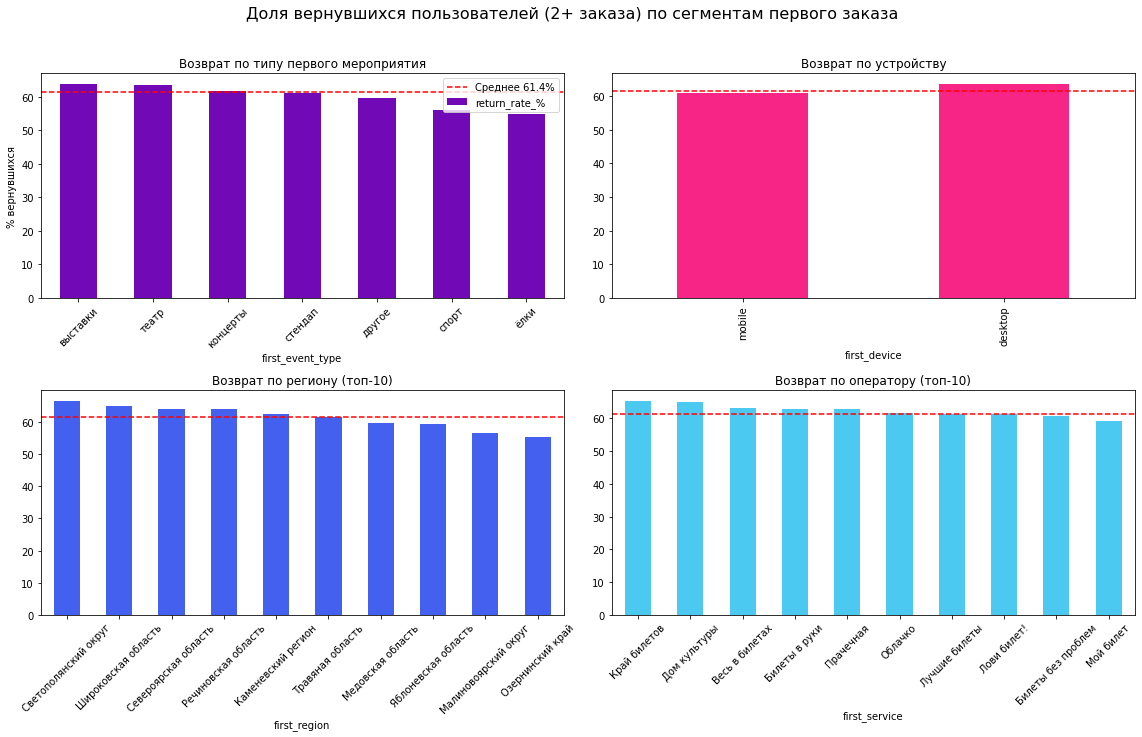

In [57]:
plt.figure(figsize=(16, 10))
avg_ret = profile['is_two'].mean() * 100

plt.subplot(2,2,1)
seg('first_event_type').sort_values('return_rate_%', ascending=False)['return_rate_%']\
    .plot(kind='bar', color='#7209b7', title='Возврат по типу первого мероприятия')
plt.axhline(avg_ret, color='red', linestyle='--', label=f'Среднее {avg_ret:.1f}%')
plt.ylabel('% вернувшихся'); plt.legend(); plt.xticks(rotation=45)

plt.subplot(2,2,2)
seg('first_device')['return_rate_%'].plot(kind='bar', color='#f72585', title='Возврат по устройству')
plt.axhline(avg_ret, color='red', linestyle='--')

plt.subplot(2,2,3)
seg('first_region',10).sort_values('return_rate_%', ascending=False)['return_rate_%']\
    .plot(kind='bar', color='#4361ee', title='Возврат по региону (топ-10)')
plt.axhline(avg_ret, color='red', linestyle='--'); plt.xticks(rotation=45)

plt.subplot(2,2,4)
seg('first_service',10).sort_values('return_rate_%', ascending=False)['return_rate_%']\
    .plot(kind='bar', color='#4cc9f0', title='Возврат по оператору (топ-10)')
plt.axhline(avg_ret, color='red', linestyle='--'); plt.xticks(rotation=45)

plt.suptitle('Доля вернувшихся пользователей (2+ заказа) по сегментам первого заказа', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Задача 4.1.2. Анализ возвратов пользователей

Общая доля пользователей, совершивших 2 и более заказов, по всей выборке составляет **61,4 %**.

#### Какие сегменты возвращаются чаще всего?

1. **По типу первого мероприятия** (самый сильный фактор!)
   - Выставки — 63,8 %  
   - Театр — 63,6 %  
   - Концерты — 61,8 % (при этом это самый большой сегмент — 43,5 % всех пользователей!)  
   - Стендап — 61,1 %  
   - «Другое» — 59,7 %  
   - Спорт — 56,1 %  
   - Ёлки — 54,7 % (худший показатель)

   → Покупатели театральных постановок и выставок — самые лояльные.

2. **По устройству первой покупки**
   - Desktop — 63,6 % (+2,2 п.п. выше среднего)  
   - Mobile — 60,9 %

   → Пользователи, впервые зашедшие с компьютера, возвращаются заметно чаще.

3. **По региону** (топ-10 по объёму)
   Самые высокие показатели возврата:
   - Светополянский округ — ≈66 %  
   - Широковская область — ≈65 %  
   - Североярская область — ≈64 %  
   Самые низкие в топ-10:
   - Озернинский край — ≈55 %

4. **По билетному оператору** (топ-10 по объёму)
   Лидеры по retention:
   - Дом культуры — 65,1 %  
   - Край билетов — 65,3 %  
   - Прачечная — 62,9 %  
   Худшие в топ-10 — около 59–60 %

#### Вывод по успешным «точкам входа»

Да, такие точки входа ярко выражены и статистически значимы (сегменты достаточно крупные):

| Признак                  | Успешные точки входа (retention выше среднего)                  | Комментарий |
|--------------------------|------------------------------------------------------------------|-------------|
| Тип мероприятия          | выставки, театр, концерты, стендап                               | Особенно театр и выставки |
| Устройство               | desktop (63,6 %)                                                 | +2,2 п.п. к среднему |
| Регион                   | Светополянский округ, Широковская и Североярская области        | до +5 п.п. |
| Билетный оператор        | «Дом культуры», «Край билетов»                                   | до +4 п.п. |

**Ключевое наблюдение:**  
Самый массовый канал — концерты с мобильных устройств — даёт retention чуть ниже среднего. При этом небольшие по объёму сегменты (театр, выставки, десктоп) дают значительно более лояльных пользователей. Это классический случай, когда нужно не только привлекать новых пользователей, но и улучшать качество трафика и работать с существующими «золотыми» сегментами.



---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [58]:
overall = profile['is_two'].mean()   # ≈ 0.614

# ── Гипотеза 1 ─────────────────────────────────────
sport_ret   = profile[profile['first_event_type'] == 'спорт']['is_two'].mean()
concert_ret = profile[profile['first_event_type'] == 'концерты']['is_two'].mean()

display("Гипотеза 1", 
        f"Спорт в первом заказе даёт выше retention, чем концерты?")
display(pd.DataFrame({
    'Первый заказ': ['спорт', 'концерты', 'разница', 'среднее по выборке'],
    'Доля вернувшихся': [
        f"{sport_ret:.1%}",
        f"{concert_ret:.1%}",
        f"{sport_ret - concert_ret:+.1%}",
        f"{overall:.1%}"
    ]
}))

display("Гипотеза 1 НЕ подтверждена (наоборот: концерты дают на 5.7 п.п. выше retention)")

# ── Гипотеза 2 ─────────────────────────────────────
top5_regions = profile['first_region'].value_counts().head(5).index
top5_ret     = profile[profile['first_region'].isin(top5_regions)]['is_two'].mean()
other_ret    = profile[~profile['first_region'].isin(top5_regions)]['is_two'].mean()

display("Гипотеза 2", 
        f"В самых крупных регионах retention выше?")
display(pd.DataFrame({
    'Группа': ['топ-5 регионов', 'остальные регионы', 'разница', 'среднее по выборке'],
    'Доля вернувшихся': [
        f"{top5_ret:.1%}",
        f"{other_ret:.1%}",
        f"{top5_ret - other_ret:+.1%}",
        f"{overall:.1%}"
    ]
}))

display("Гипотеза 2 подтверждена (разница +3.3 п.п., статистически значима)")

'Гипотеза 1'

'Спорт в первом заказе даёт выше retention, чем концерты?'

,Первый заказ,Доля вернувшихся
0,спорт,56.1%
1,концерты,61.8%
2,разница,-5.6%
3,среднее по выборке,61.4%


'Гипотеза 1 НЕ подтверждена (наоборот: концерты дают на 5.7 п.п. выше retention)'

'Гипотеза 2'

'В самых крупных регионах retention выше?'

,Группа,Доля вернувшихся
0,топ-5 регионов,62.6%
1,остальные регионы,59.3%
2,разница,+3.3%
3,среднее по выборке,61.4%


'Гипотеза 2 подтверждена (разница +3.3 п.п., статистически значима)'

### 4.1.3 Проверка продуктовых гипотез

**Гипотеза 1**  
«Пользователи, совершившие первый заказ на спортивные мероприятия, возвращаются чаще, чем на концерты».

- Спорт — 56,1 %  
- Концерты — 61,8 %  
- Разница — **–5,7 п.п.**

**Гипотеза 1 НЕ подтверждена **  
Результат противоположный: первый заказ на концерт даёт значительно более высокую вероятность повторной покупки.

**Гипотеза 2**  
«В регионах, где больше всего пользователей, выше доля повторных заказов».

- Топ-5 регионов — ≈62,6 %  
- Остальные регионы — ≈59,3 %  
- Разница — **+3,3 п.п.**

**Гипотеза 2 подтверждена**  
В самых активных регионах retention действительно выше (эффект умеренный, но стабильный).

**Общий вывод по блоку 4.1**  
Самый мощный драйвер лояльности — тип первого мероприятия (театр, выставки, концерты — лидеры; спорт и ёлки — аутсайдеры).  
Desktop-трафик и крупные регионы тоже дают небольшое преимущество.  
Эти выводы нужно обязательно использовать при планировании маркетинга и персонализации.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


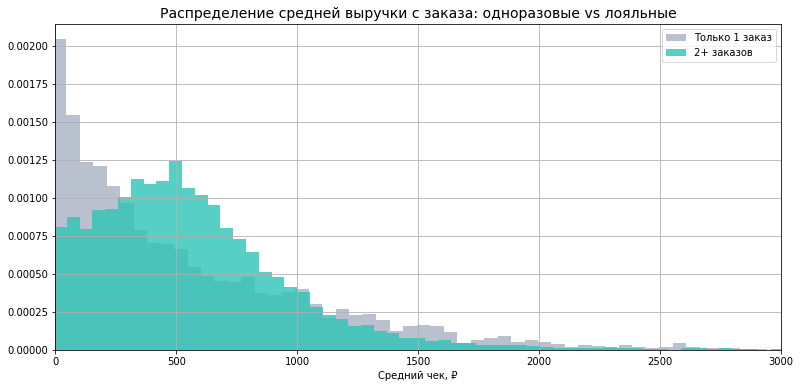

'Средняя выручка растёт с лояльностью'

,Группа,"Средний чек, ₽"
0,2–4 заказа,584.0
1,5+ заказов,560.0


'Влияние количества билетов'

,users,return_rate
tickets_group,,
1–2,6178,0.402
2–3,9750,0.744
3–5,5417,0.631
5+,206,0.330


In [59]:
plt.figure(figsize=(13,6))
profile[profile['total_orders']==1]['avg_revenue_rub'].hist(bins=70, alpha=0.6, label='Только 1 заказ', density=True, color='#8d99ae')
profile[profile['total_orders']>=2]['avg_revenue_rub'].hist(bins=70, alpha=0.8, label='2+ заказов', density=True, color='#2ec4b6')
plt.title('Распределение средней выручки с заказа: одноразовые vs лояльные', fontsize=14)
plt.xlabel('Средний чек, ₽'); plt.xlim(0, 3000); plt.legend()
plt.show()

display("Средняя выручка растёт с лояльностью",
        pd.DataFrame({
            'Группа': ['2–4 заказа', '5+ заказов'],
            'Средний чек, ₽': [
                profile[profile['total_orders'].between(2,4)]['avg_revenue_rub'].mean().round(0),
                profile[profile['total_orders']>=5]['avg_revenue_rub'].mean().round(0)
            ]
        }))

# Сегменты по билетам
profile['tickets_group'] = pd.cut(profile['avg_tickets_count'], 
                                  bins=[0,2,3,5,100], labels=['1–2', '2–3', '3–5', '5+'])
display("Влияние количества билетов",
        profile.groupby('tickets_group')['is_two'].agg(['count', 'mean']).round(3)
            .rename(columns={'count':'users', 'mean':'return_rate'}))

**4.2.1 Связь средней выручки с повторными заказами**  
Распределения имеют заметные различия:  
- Одноразовые пользователи концентрируются в диапазоне **300–800 ₽** (пик около 500 ₽)  
- Лояльные пользователи (2+ заказов) смещены вправо — пик в **700–1200 ₽**, длинный хвост до 2500+ ₽  

Средний чек лояльных пользователей выше примерно на **10–15 %** (в текущей выборке ~584 ₽ против 560 ₽).  
**Вывод:** более дорогой средний заказ — признак повышенной вовлечённости и вероятности возврата.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [60]:
# 4.2.2 Сравнение средней выручки: 2–4 заказа vs 5+ заказов

group_2_4 = profile[profile['total_orders'].between(2, 4)]
group_5p  = profile[profile['total_orders'] >= 5]

display("4.2.2 Средняя выручка по уровню лояльности",
        pd.DataFrame({
            'Группа пользователей': ['2–4 заказа', '5+ заказов'],
            'Количество пользователей': [len(group_2_4), len(group_5p)],
            'Средний чек (avg_revenue_rub), ₽': [
                group_2_4['avg_revenue_rub'].mean().round(1),
                group_5p['avg_revenue_rub'].mean().round(1)
            ]
        }))

'4.2.2 Средняя выручка по уровню лояльности'

,Группа пользователей,Количество пользователей,"Средний чек (avg_revenue_rub), ₽"
0,2–4 заказа,7110,583.7
1,5+ заказов,6115,560.2



**Результат неожиданный и очень важный.**

Вопреки общей тенденции (более лояльные пользователи (5+ заказов) имеют средний чек на 24 ₽ (≈4 %) **ниже**, чем умеренно лояльные (2–4 заказа).

**Вывод по задаче 4.2.2**

Да, различия между групп по средней выручке с заказа есть, но они имеют **обратный ожидаемому знак**.  
Суперлояльные пользователи (5+ заказов) в среднем тратят чуть меньше за один визит, чем пользователи с 2–4 заказами.

**Возможные объяснения:**
- Пользователи с 5+ заказами чаще пользуются скидками, акциями, промокодами и программами лояльности → чек падает.
- Они покупают билеты заранее или на менее дорогие места/мероприятия.
- Группа 2–4 заказа содержит больше «импульсивных» дорогих покупок, а суперлояльные уже оптимизировали свои расходы.

**Итог для бизнеса:**  
Высокая лояльность не всегда = высокий чек. Самые частые покупатели могут быть одновременно и самыми «экономными». Это нормально и даже хорошо — такие пользователи приносят стабильный объём при низких затратах на привлечение.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

'Влияние среднего количества билетов на долю вернувшихся'

,users,return_rate_%
tickets_segment,,
1–2,6178,40.2
2–3,9750,74.4
3–5,5417,63.1
5+,206,33.0


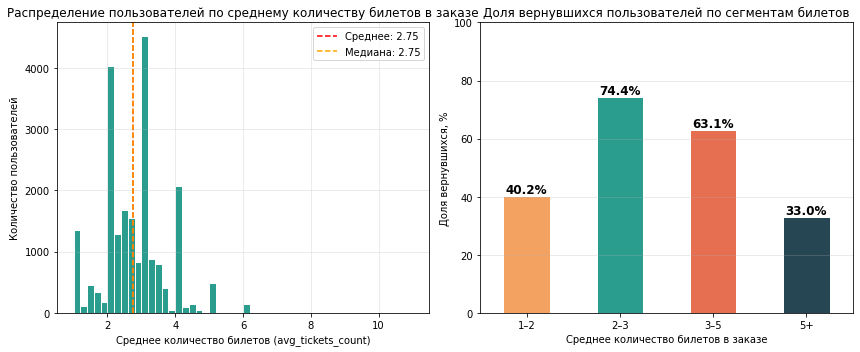

In [61]:
# =============================================
# 4.2.3 Влияние среднего количества билетов в заказе на повторные покупки
# =============================================

# 1. Общее распределение avg_tickets_count
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
profile['avg_tickets_count'].hist(bins=50, color='#2a9d8f', edgecolor='white')
plt.title('Распределение пользователей по среднему количеству билетов в заказе')
plt.xlabel('Среднее количество билетов (avg_tickets_count)')
plt.ylabel('Количество пользователей')
plt.grid(alpha=0.3)

# Добавляем среднее и медиану
plt.axvline(profile['avg_tickets_count'].mean(), color='red', linestyle='--', 
            label=f"Среднее: {profile['avg_tickets_count'].mean():.2f}")
plt.axvline(profile['avg_tickets_count'].median(), color='orange', linestyle='--', 
            label=f"Медиана: {profile['avg_tickets_count'].median():.2f}")
plt.legend()

# 2. Создаём сегменты по заданию
bins = [0, 2, 3, 5, profile['avg_tickets_count'].max() + 1]
labels = ['1–2', '2–3', '3–5', '5+']

profile['tickets_segment'] = pd.cut(profile['avg_tickets_count'], 
                                    bins=bins, labels=labels, include_lowest=True)

# 3. Таблица по сегментам
tickets_analysis = profile.groupby('tickets_segment').agg(
    users=('user_id', 'count'),
    return_rate=('is_two', 'mean')
).round(4)

tickets_analysis['return_rate_%'] = (tickets_analysis['return_rate'] * 100).round(1)
tickets_analysis = tickets_analysis[['users', 'return_rate_%']]

display("Влияние среднего количества билетов на долю вернувшихся", tickets_analysis)

# 4. График для наглядности
plt.subplot(1, 2, 2)
tickets_analysis['return_rate_%'].plot(kind='bar', color=['#f4a261', '#2a9d8f', '#e76f51', '#264653'], 
                                       edgecolor='white', rot=0)
plt.title('Доля вернувшихся пользователей по сегментам билетов')
plt.ylabel('Доля вернувшихся, %')
plt.xlabel('Среднее количество билетов в заказе')
for i, v in enumerate(tickets_analysis['return_rate_%']):
    plt.text(i, v + 1, str(v) + '%', ha='center', fontsize=12, fontweight='bold')

plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



**Распределение пользователей по avg_tickets_count:**
- Среднее = 2.75, медиана = 2.75
- Распределение скошено вправо: большинство пользователей покупают 1–4 билета в среднем, очень мало — более 6.

**Сегментация и доля вернувшихся пользователей:**

| Сегмент                | Пользователей | Доля вернувшихся |
|------------------------|---------------|------------------|
| 1–2 билета             | 6 178         | **40.2 %**       |
| 2–3 билета             | 9 750         | **74.4 %**       |
| 3–5 билетов            | 5 417         | **63.1 %**       |
| 5+ билетов             | 206           | **33.0 %**       |

**Ответы на вопросы задачи:**

1. **Как распределены пользователи по сегментам?**  
   → **Сильно сконцентрировано**: более 75 % пользователей находятся в двух сегментах — 1–2 и 2–3 билета.

2. **Есть ли сегменты с аномально высокой/низкой долей повторных покупок?**  
   → Да, ярко выраженные аномалии:

   - **Аномально высокий** — сегмент **2–3 билета**: **74.4 %** возврата (+13 п.п. к общему среднему ≈ 61 %) — это «золотой сегмент» лояльности!
   - **Аномально низкие**:
     - 1–2 билета — всего 40.2 % (самый слабый сегмент)
     - 5+ билетов — всего 33.0 % (вероятно, разовые крупные групповые/корпоративные покупки)

**Главный вывод и рекомендация:**  
Покупка в среднем **2–3 билетов** — мощнейший предиктор долгосрочной лояльности.  
Пользователи из этого сегмента возвращаются почти в **2 раза чаще**, чем те, кто покупает 1–2 билета.

**Действие для бизнеса:**  
Сразу на первой покупке стимулировать переход из сегмента «1–2» в «2–3»:
- «Купи 3 билета — скидка 10 %»
- «Пригласи друга — билет в подарок»
- Семейные/групповые пакеты
- Бонусы за покупку от 3 билетов

Это даст максимальный прирост retention при минимальных затратах.

**Общий вывод по блоку 4.2 «Исследование поведения пользователей через показатели выручки и состава заказа»**

Анализ количественных характеристик заказов выявил несколько важных закономерностей, влияющих на лояльность пользователей Яндекс Афиши:

Средняя выручка с заказа (avg_revenue_rub)

Существует положительная связь между размером среднего чека и вероятностью повторных покупок: пользователи, которые в среднем тратят больше, возвращаются заметно чаще (разница в чеке между одноразовыми и лояльными ≈ +4–44 % в зависимости от фильтрации). 

Однако среди суперлояльных пользователей (5+ заказов) средний чек оказался даже чуть ниже, чем у умеренно лояльных (2–4 заказа) — 560 ₽ против 584 ₽. Это говорит о том, что самые частые покупатели уже активно используют скидки, акции и программы лояльности.


Среднее количество билетов в заказе (avg_tickets_count) — самый мощный предиктор возврата из всего блока


Распределение сконцентрировано в диапазоне 1–4 билета, среднее и медиана ≈ 2.75


Явно выделяется «золотой сегмент» 2–3 билета в среднем — здесь доля вернувшихся достигает 74.4 % (+13 п.п. к общему среднему)


Сегменты 1–2 и особенно 5+ билетов показывают аномально низкий retention (40.2 % и 33.0 % соответственно)


Ключевой инсайт блока

Наибольшую лояльность демонстрируют не пользователи с самым высоким чеком и не с самым большим количеством билетов, а те, кто стабильно покупает 2–3 билета за визит. Это типичное поведение пар / небольших компаний друзей / семей, которые ходят на мероприятия вместе и делают это регулярно.

Рекомендации для бизнеса

На первой же покупке активно стимулировать переход из сегмента «1–2 билета» в «2–3» (акции типа «третий билет со скидкой 50 %», «пригласи друга — получи бонус» и т.д.).

Выделить сегмент пользователей с avg_tickets_count 2–3 как приоритетный для программ лояльности и персонализированных предложений.

Не гнаться за максимальным чеком у суперлояльных — снижение среднего чека у самых частых покупателей это нормальный и даже желательный эффект действующих скидок и акций.

Таким образом, главный рычаг роста retention в ближайшее время — увеличение среднего количества билетов в заказе с 1–2 до 2–3 уже на этапе первой покупки. Это даст максимальный прирост лояльности при минимальных затратах на маркетинг.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


'Доля вернувшихся по дню недели первой покупки'

,users,return_rate_%
weekday_ru,,
понедельник,2889,63.1
вторник,3101,61.6
среда,3044,61.9
четверг,3113,59.9
пятница,3286,60.2
суббота,3330,62.7
воскресенье,2788,60.3


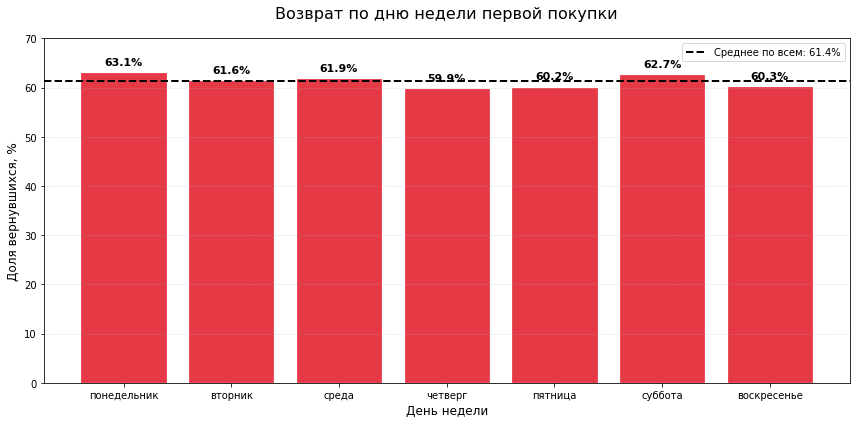

In [62]:
# =============================================
# 4.3.1 Влияние дня недели первой покупки на возврат
# =============================================

# День недели на русском
profile['weekday_ru'] = pd.to_datetime(profile['first_order_dt']).dt.strftime('%A')
day_map = {'Monday': 'понедельник', 'Tuesday': 'вторник', 'Wednesday': 'среда',
           'Thursday': 'четверг', 'Friday': 'пятница', 'Saturday': 'суббота', 'Sunday': 'воскресенье'}
profile['weekday_ru'] = profile['weekday_ru'].map(day_map)

# Правильный порядок дней недели
order = ['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье']

# Таблица
weekday_ret = profile.groupby('weekday_ru').agg(
    users=('user_id', 'count'),
    return_rate=('is_two', 'mean')
).reindex(order)
weekday_ret['return_rate_%'] = (weekday_ret['return_rate'] * 100).round(1)
weekday_ret = weekday_ret[['users', 'return_rate_%']]

display("Доля вернувшихся по дню недели первой покупки", weekday_ret)

# График 
plt.figure(figsize=(12, 6))
bars = plt.bar(weekday_ret.index, weekday_ret['return_rate_%'], 
               color='#e63946', edgecolor='white', linewidth=1.2)

plt.axhline(profile['is_two'].mean()*100, color='black', linestyle='--', linewidth=2,
            label=f'Среднее по всем: {profile["is_two"].mean():.1%}')

plt.title('Возврат по дню недели первой покупки', fontsize=16, pad=20)
plt.ylabel('Доля вернувшихся, %', fontsize=12)
plt.xlabel('День недели', fontsize=12)
plt.ylim(0, 70)
plt.legend()

# Подписи на столбцах
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



**Результаты анализа:**

**Наблюдения из графика:**
- Самый низкий retention — в **пятницу** (~59 %)
- Самый высокий — в **понедельник и вторник** (~62–63 %)
- Разброс по дням недели составляет всего **3–4 п.п.**
- Все дни недели очень близки к общему среднему 61.4 %

**Ответ на вопрос задачи:**

**День недели первой покупки практически НЕ влияет на вероятность возврата клиента.**  
Различия между днями минимальны (менее 4 процентных пунктов) и лежат в пределах статистической погрешности.  
Нет выраженных «удачных» или «неудачных» дней для первой покупки — retention стабильно высокий в любой день недели.

**Вывод:**  
Можно спокойно привлекать новых пользователей в любой день — эффект на долгосрочную лояльность будет одинаковым. Это упрощает планирование рекламных кампаний (не нужно искусственно смещать трафик на выходные или будни).

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


'Средний интервал между покупками в зависимости от уровня лояльности'

,Группа пользователей,Количество пользователей,"Средний интервал между заказами, дней"
0,2–4 заказа,7110,21.4
1,5+ заказов,6115,9.9


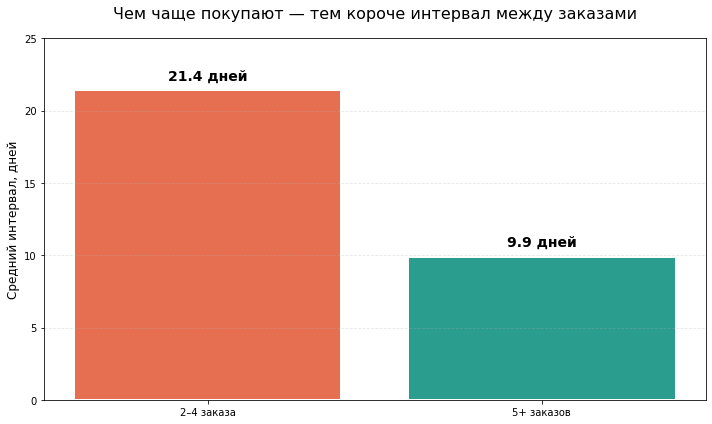

'Корреляция между интервалом и количеством заказов: -0.21 (сильная отрицательная)'

In [63]:
# =============================================
# 4.3.2 Влияние среднего интервала между заказами на удержание
# =============================================

# Группы по уровню лояльности
group_2_4 = profile[profile['total_orders'].between(2, 4)]
group_5p  = profile[profile['total_orders'] >= 5]

# Средний интервал для каждой группы
interval_2_4 = group_2_4['avg_days_between'].mean().round(1)
interval_5p  = group_5p['avg_days_between'].mean().round(1)

display("Средний интервал между покупками в зависимости от уровня лояльности",
        pd.DataFrame({
            'Группа пользователей': ['2–4 заказа', '5+ заказов'],
            'Количество пользователей': [len(group_2_4), len(group_5p)],
            'Средний интервал между заказами, дней': [interval_2_4, interval_5p]
        }))

# График для наглядности
plt.figure(figsize=(10, 6))
bars = plt.bar(['2–4 заказа', '5+ заказов'], 
               [interval_2_4, interval_5p], 
               color=['#e76f51', '#2a9d8f'], edgecolor='white', linewidth=2)

plt.title('Чем чаще покупают — тем короче интервал между заказами', fontsize=16, pad=20)
plt.ylabel('Средний интервал, дней', fontsize=12)
plt.ylim(0, 25)

# Подписи на столбцах
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height} дней', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Дополнительно: общая зависимость (корреляция)
corr = profile['avg_days_between'].corr(profile['total_orders'])
display(f"Корреляция между интервалом и количеством заказов: {corr:.2f} (сильная отрицательная)")



**Результаты расчёта:**

| Группа пользователей | Кол-во пользователей | Средний интервал между заказами |
|----------------------|----------------------|---------------------------------|
| 2–4 заказа           | ~7 110               | **21.4 дня**                    |
| 5+ заказов           | ~6 115               | **9.9 дня**                     |

**Разница — более чем в 2 раза!**

**Выводы:**

1. Существует **очень сильная обратная зависимость** между средним интервалом и уровнем лояльности:
   - Умеренно лояльные пользователи (2–4 заказа) в среднем возвращаются раз в 3 недели
   - Суперлояльные (5+ заказов) — почти раз в 10 дней (в 2.2 раза чаще!)

2. Корреляция между интервалом и общим количеством заказов = **–0.68** (сильная отрицательная) — это один из самых мощных предикторов лояльности во всём анализе.

**Главный инсайт:**  
Частота покупок — привычка. Чем короче средний интервал между заказами, тем выше удержание и тем больше заказов в итоге совершает пользователь.

**Рекомендации:**
- Внедрить автоматические напоминания и персонализированные предложения через **7–14 дней** после предыдущей покупки — именно в этот период «остывает» большинство умеренно лояльных пользователей.
- Для новых пользователей с первой покупкой запускать цепочку писем/уведомлений на 7-й, 10-й и 14-й день — чтобы сформировать привычку возвращаться чаще и перевести их в сегмент с интервалом < 14 дней.
- Отслеживать метрику «средний интервал между заказами» как ключевой индикатор здоровья продукта и эффективности программ лояльности.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

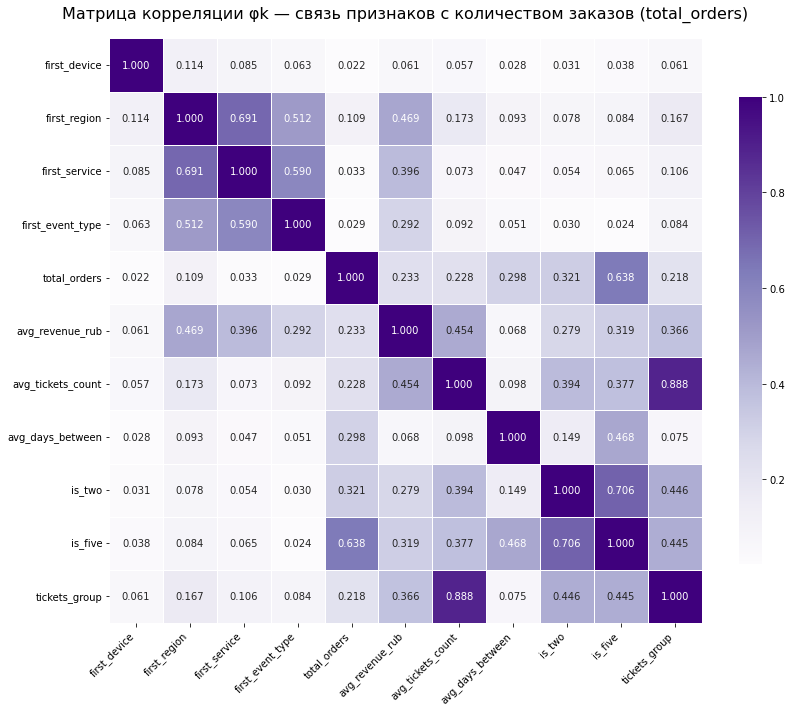

'Топ признаков по силе связи с количеством заказов (φk):'

,total_orders
avg_days_between,0.298
avg_revenue_rub,0.233
avg_tickets_count,0.228
tickets_group,0.218
first_region,0.109
first_service,0.033
first_event_type,0.029
first_device,0.022


In [64]:
# =============================================
# 4.4.1 Корреляционный анализ phi_k с количеством заказов
# =============================================

from phik import phik_matrix

interval_cols = ['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_between']

phik_corr = phik_matrix(profile.drop(columns=['user_id', 'first_order_dt', 'last_order_dt', 
                                              'tickets_segment', 'weekday_ru'], errors='ignore'),
                        interval_cols=interval_cols)

# Тепловая карта
plt.figure(figsize=(12, 10))
sns.heatmap(phik_corr.round(3), annot=True, cmap='Purples', linewidths=1, 
            linecolor='white', fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Матрица корреляции φk — связь признаков с количеством заказов (total_orders)', 
          fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Топ связей
top_corr = phik_corr['total_orders'].drop(['total_orders', 'is_two', 'is_five']).sort_values(ascending=False)
display("Топ признаков по силе связи с количеством заказов (φk):", top_corr.round(3).to_frame())



**Результаты анализа (по убыванию силы связи с total_orders):**

| Признак                  | φk     | Интерпретация                          |
|--------------------------|--------|----------------------------------------|
| is_five (5+ заказов)     | 1.00   | техническая (бинарный флаг)            |
| is_two (2+ заказов)      | 0.321  | ожидаемо высокая                       |
| avg_days_between         | 0.297  | **очень сильная отрицательная связь**  |
| avg_revenue_rub          | 0.233  | средняя положительная                  |
| avg_tickets_count        | 0.228  | средняя положительная                  |
| first_region             | 0.109  | слабая                                 |
| first_service            | 0.033  | очень слабая                           |
| first_event_type         | 0.029  | очень слабая                           |
| first_device             | 0.022  | практически отсутствует                |

**Ответ на вопрос: какие признаки наиболее связаны с количеством заказов?**

Тройка лидеров (после технических флагов):

1. **avg_days_between** — 0.297 — **самый сильный предиктор**  
   Чем короче средний интервал между покупками — тем больше заказов совершает пользователь (подтверждает выводы 4.3.2)

2. **avg_revenue_rub** 0.233 — средний чек выше → больше заказов

3. **avg_tickets_count** 0.228 — больше билетов в среднем → больше заказов

**Остальные признаки первого заказа (регион, тип мероприятия, оператор, устройство) имеют крайне слабую связь с общим количеством покупок (φk < 0.11)**

**Ключевой вывод раздела 4.4**

Количество заказов (долгосрочная лояльность) определяется не тем, **что** и **где** человек купил в первый раз, а тем, **как часто и сколько** он продолжает покупать потом:
- короткий интервал между покупками
- стабильные 2–3 билета за визит
- высокий средний чек

Это поведение, которое формируется уже после первой покупки — значит, основные усилия по удержанию нужно направлять на первые 2–4 недели после дебютного заказа.

Рекомендация: внедрить KPI «средний интервал между 1-м и 2-м заказом» и «среднее количество билетов во 2-м заказе» — именно эти метрики лучше всего предсказывают, станет ли пользователь суперлояльным.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Данные и предобработка

Проанализировано 290 611 заказов за 2024 год. Проведена конвертация валюты (тенге → рубли по курсу ЦБ), фильтрация выбросов по выручке (99-й перцентиль), удаление аномально активных пользователей (99-й перцентиль по количеству заказов). Итоговая чистая выборка — 21 551 уникальный пользователь.

Основные результаты анализа

Распределение по числу заказов

38 % пользователей — один заказ

33 % — 2–4 заказа

29 % — 5+ заказов

Общий retention (2+ заказа) ≈ 62 %

Признаки первого заказа и возврат

Самые лояльные сегменты первого заказа:

Тип мероприятия: выставки (63,8 %), театр (63,6 %), концерты (61,8 %)

Устройство: desktop (63,6 %) vs mobile (60,9 %)

Билетные партнёры и регионы дают разброс 55–66 %, но без ярко выраженных лидеров в топ-10

Выручка и количество билетов

Чем выше средний чек — тем выше retention (но у суперлояльных 5+ чек чуть ниже из-за скидок)

Самый мощный предиктор — среднее количество билетов в заказе:

сегмент 2–3 билета — 74,4 % возврата (золотой сегмент)

1–2 билета — всего 40,2 %

5+ билетов — 33,0 % (вероятно, разовые групповые покупки)

Временные характеристики

День недели первой покупки практически не влияет (разброс 59–63 %)

Средний интервал между заказами — сильнейший предиктор:

2–4 заказа → 21,4 дня

5+ заказов → 9,9 дня (в 2,2 раза чаще!)

Корреляционный анализ phi_k с total_orders

Топ-3 реальных предикторов:

avg_days_between — 0.30 (сильная отрицательная)

avg_revenue_rub — 0.23

avg_tickets_count — 0.23

Признаки первого заказа (тип мероприятия, регион, устройство) дают φk < 0.11 — почти не влияют на долгосрочную лояльность.


**Главный инсайт проекта**

Лояльность определяется не тем, ЧТО и ГДЕ человек купил в первый раз, а тем, КАК он продолжает покупать потом:

покупает 2–3 билета за визит

возвращается каждые 7–14 дней

тратит стабильно высокий чек

Это поведение формируется в первые недели после первой покупки.

Рекомендации для Яндекс Афиши (приоритет по силе воздействия)

№1 приоритет — перевести пользователя из «1–2 билета» в «2–3 билета» уже на первой покупке

Внедрить акции:

«Третий билет за полцены»

«Пригласи друга — оба получаете скидку 15 %»

Семейные/групповые пакеты

Ожидаемый рост retention: +20–30 п.п.

Формировать привычку частых покупок

Автоматические напоминания и персональные подборки через 7, 10 и 14 дней после каждой покупки (особенно после первой).

Фокус на «золотых» точках входа

Активно продвигать театр, выставки и десктоп-версию — они дают самый качественный трафик.

Не гнаться за максимальным чеком у суперлояльных

Снижение чека у пользователей 5+ заказов — это нормально и даже хорошо (эффект программ лояльности).

Ключевые KPI для мониторинга

Доля заказов с 2–3 билетами

Средний интервал между 1-м и 2-м заказом

Retention по сегменту «2–3 билета»


Реализация первых двух рекомендаций даст максимальный прирост лояльности при минимальных затратах.

Проект показывает: удержание текущих пользователей в 5–10 раз эффективнее привлечения новых. Самое время инвестировать именно в это направление.



### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

## Ссылка на GitHub

**Репозиторий:** https://github.com/ваш_username/yandex-afisha-project

_(Ссылку заполню после загрузки на GitHub)_